# **Skenario 1 - CNN VGG16**

Skenario 1 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

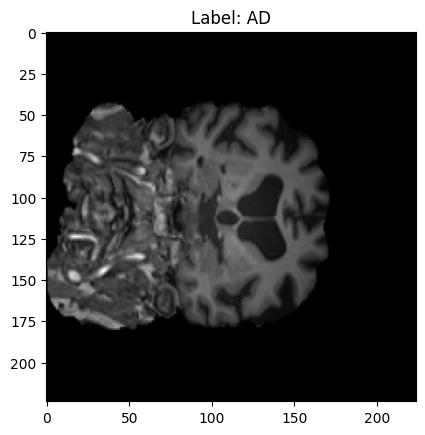

In [4]:
index_to_visualize = 0
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data

In [6]:
# Bagi dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


## 3. Buat dan Konfigurasi Model

Arsitektur yang digunakan yaitu VGG16 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [8]:
def create_model(input_shape=(224, 224, 3)):
    # Use VGG16 as a layer in your model
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    # Freeze the weights of the pre-trained model
    base_model.trainable = False

    # Use the output of the pre-trained model as input for the custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    # Create the final model
    model = Model(base_model.input, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
model = create_model()
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [10]:
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25


360/360 [==============================] - 595s 2s/step - loss: 1.8353 - accuracy: 0.3776 - val_loss: 1.1459 - val_accuracy: 0.4674
Epoch 2/25
360/360 [==============================] - 598s 2s/step - loss: 1.2110 - accuracy: 0.4378 - val_loss: 1.1597 - val_accuracy: 0.4917
Epoch 3/25
360/360 [==============================] - 601s 2s/step - loss: 1.1216 - accuracy: 0.4938 - val_loss: 1.0627 - val_accuracy: 0.5382
Epoch 4/25
360/360 [==============================] - 603s 2s/step - loss: 0.9988 - accuracy: 0.5668 - val_loss: 0.9766 - val_accuracy: 0.5667
Epoch 5/25
360/360 [==============================] - 602s 2s/step - loss: 0.8668 - accuracy: 0.6392 - val_loss: 1.0029 - val_accuracy: 0.5722
Epoch 6/25
360/360 [==============================] - 603s 2s/step - loss: 0.8002 - accuracy: 0.6755 - val_loss: 0.9209 - val_accuracy: 0.6215
Epoch 7/25
360/360 [==============================] - 603s 2s/step - loss: 0.7159 - accuracy: 0.7132 - val_loss: 0.8210 - val_accuracy: 0.67

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 92s 2s/step - loss: 0.6218 - accuracy: 0.8243
Loss: 0.6218193173408508
Accuracy: 0.824305534362793
45/45 [==============================] - 92s 2s/step
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [1 1 2 ... 1 1 1]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

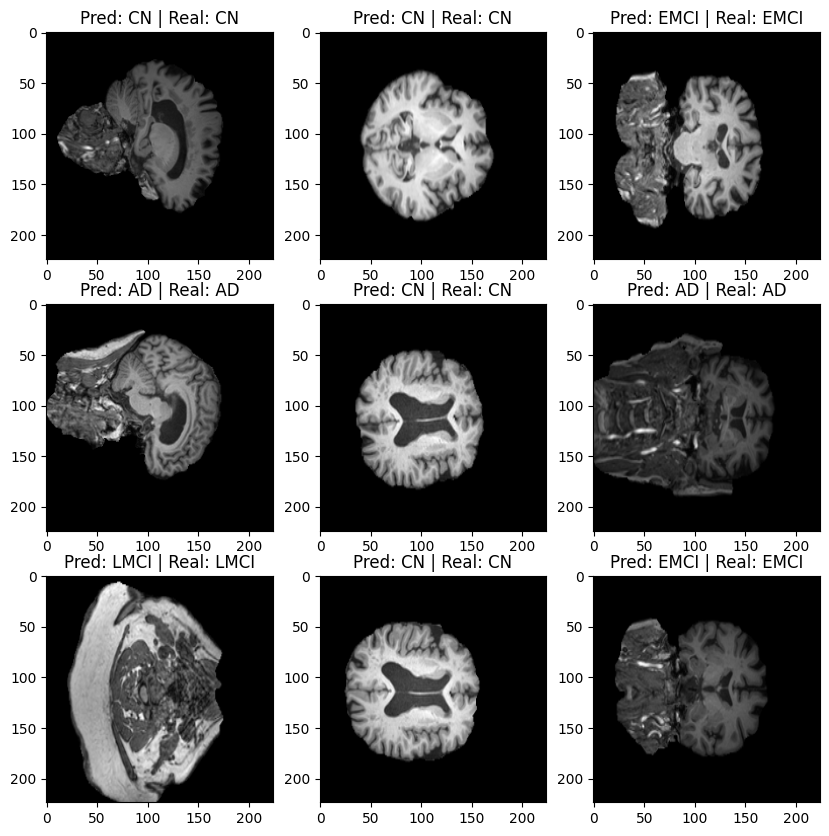

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i].astype("int64"))
    plt.imshow(X_test[i],cmap="gray")
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [13]:
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Matriks pada data train

In [14]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 370s 2s/step - loss: 0.0972 - accuracy: 0.9736 - specificity: 0.9920 - sensitivity: 0.9717
Loss train set:  0.09717869013547897
Akurasi train set:  0.9736111164093018
Specificity train set:  0.9919556379318237
Sensitivity train set:  0.9717013835906982


Matriks pada data test

In [15]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss test set: ', loss)
print('Akurasi test set: ', accuracy)
print('Specificity test set: ', specificity)
print('Sensitivity test set: ', sensitivity)

45/45 [==============================] - 92s 2s/step - loss: 0.6218 - accuracy: 0.8243 - specificity: 0.9424 - sensitivity: 0.8222
Loss test set:  0.6218193173408508
Akurasi test set:  0.824305534362793
Specificity test set:  0.9423609375953674
Sensitivity test set:  0.8222222328186035


### 6.2 Confusion Matrix dan Classification Report

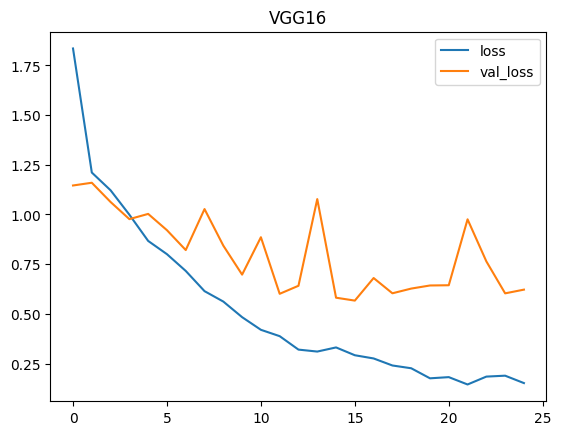

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('VGG16')
plt.show()

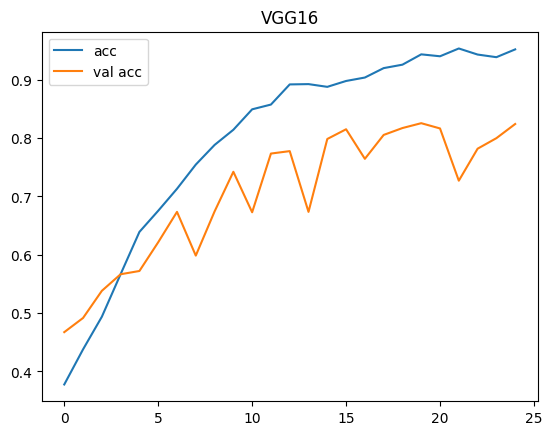

In [17]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('VGG16')
plt.show()

In [20]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\VGG16.h5")

In [21]:
# Prediksi model pd X_test
y_preds =  model.predict(X_test)
y_preds

45/45 [==============================] - 89s 2s/step


array([[7.5947045e-04, 9.4733906e-01, 1.0548886e-02, 4.1352522e-02],
       [4.8697633e-03, 9.7129560e-01, 8.0138561e-04, 2.3033272e-02],
       [3.6067273e-12, 1.7189333e-05, 9.9996996e-01, 1.2901588e-05],
       ...,
       [2.8012109e-03, 9.6934044e-01, 1.4530979e-03, 2.6405171e-02],
       [2.7009156e-02, 9.5773113e-01, 1.5193482e-04, 1.5107786e-02],
       [3.8924447e-04, 9.0988821e-01, 3.7819240e-02, 5.1903214e-02]],
      dtype=float32)

In [22]:
# Ambil indeks nilai tertinggi dari tiap pred
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([1, 1, 2, ..., 1, 1, 1], dtype=int64)

In [23]:
# Ambil indeks nilai maks dari tiap label sebenarnya
qwe=np.argmax(Y_test, axis=1)

In [24]:
confusion_matrix(qwe,y_preds_ind)

array([[305,  71,   1,   3],
       [ 20, 290,  27,   1],
       [  0,  40, 318,   5],
       [ 10,  45,  30, 274]], dtype=int64)

In [25]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       380
           1       0.65      0.86      0.74       338
           2       0.85      0.88      0.86       363
           3       0.97      0.76      0.85       359

    accuracy                           0.82      1440
   macro avg       0.84      0.82      0.83      1440
weighted avg       0.85      0.82      0.83      1440



In [26]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 91s 2s/step - loss: 0.6218 - accuracy: 0.8243 - specificity: 0.9424 - sensitivity: 0.8222


[0.6218193173408508, 0.824305534362793, 0.9423609375953674, 0.8222222328186035]

### 6.3 ROC AUC Curve

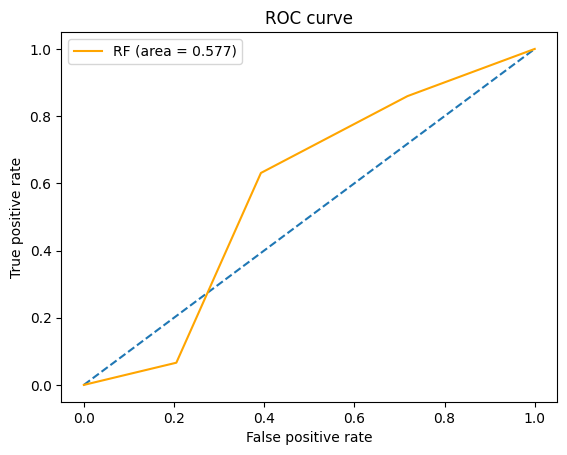

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

# auc = auc(fpr, tpr)

# import matplotlib.pyplot as plt
# plt.figure(1)
# plt.plot([0, 1], [0, 1],"--")

# plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

Hasil visualisasinya

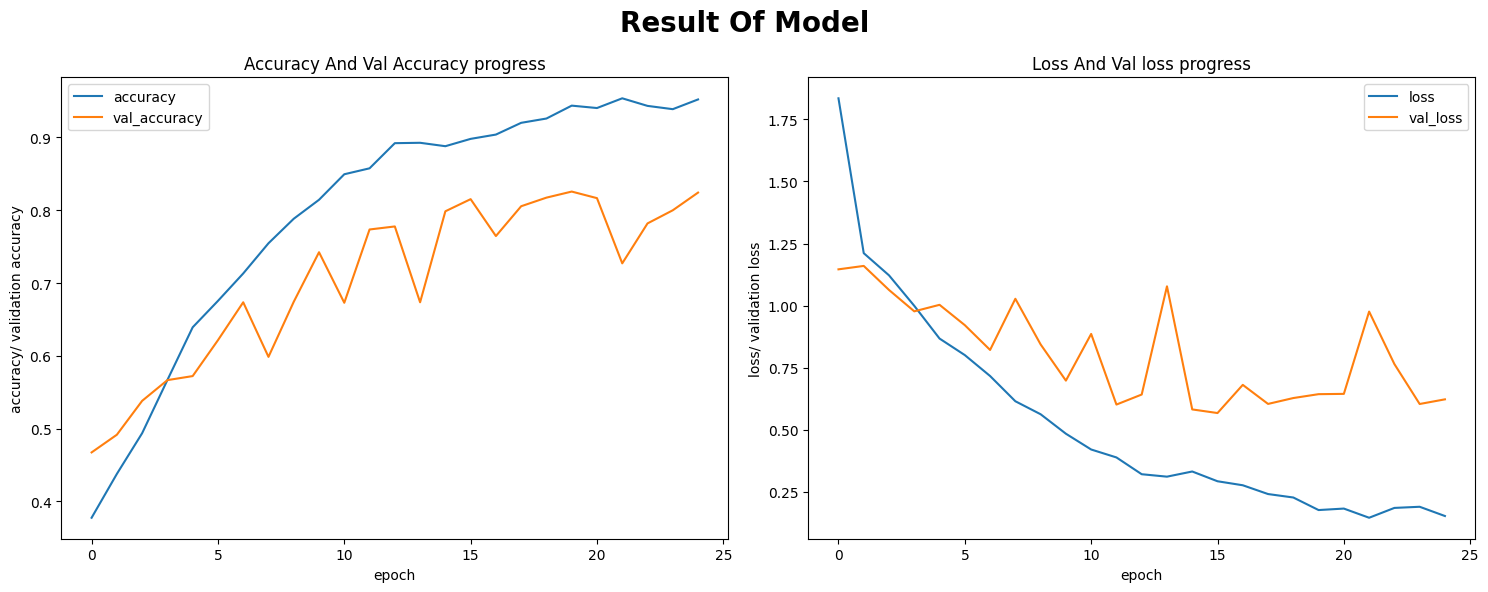

In [27]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross - Validation

In [28]:
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5', verbose=1, save_best_only=True)

# Define a function to fit the model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16, model=model):
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [29]:
n_folds = 5
epochs = 20
batch_size = 16

# Save the model history after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                                random_state=np.random.randint(1, 1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
288/288 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9280 - specificity: 0.9779 - sensitivity: 0.9236
Epoch 1: val_loss improved from inf to 0.13555, saving model to D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/288 [==============================] - 535s 2s/step - loss: 0.2442 - accuracy: 0.9280 - specificity: 0.9779 - sensitivity: 0.9236 - val_loss: 0.1355 - val_accuracy: 0.9679 - val_specificity: 0.9899 - val_sensitivity: 0.9644
Epoch 2/20
288/288 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9410 - specificity: 0.9815 - sensitivity: 0.9377
Epoch 2: val_loss did not improve from 0.13555
288/288 [==============================] - 481s 2s/step - loss: 0.2018 - accuracy: 0.9410 - specificity: 0.9815 - sensitivity: 0.9377 - val_loss: 0.1967 - val_accuracy: 0.9410 - val_specificity: 0.9815 - val_sensitivity: 0.9410
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9310 - specificity: 0.9786 - sensitivity: 0.9269
Epoch 3: val_loss improved from 0.13555 to 0.13461, saving model to D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5
288/288 [==============================] - 526s 2s/step - loss: 0.2143 - accuracy: 0.9310 - specificity: 0.9

### 7.2. Evaluasi Cross - Validation

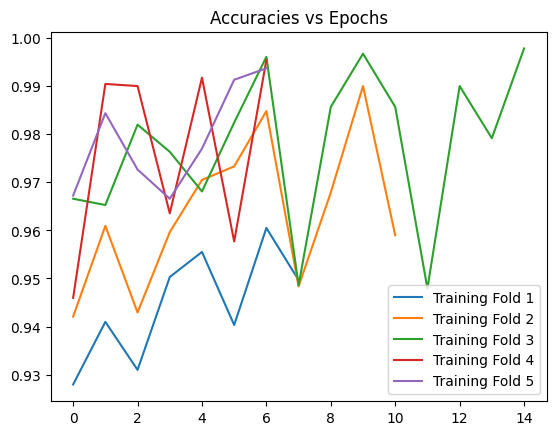

In [30]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()

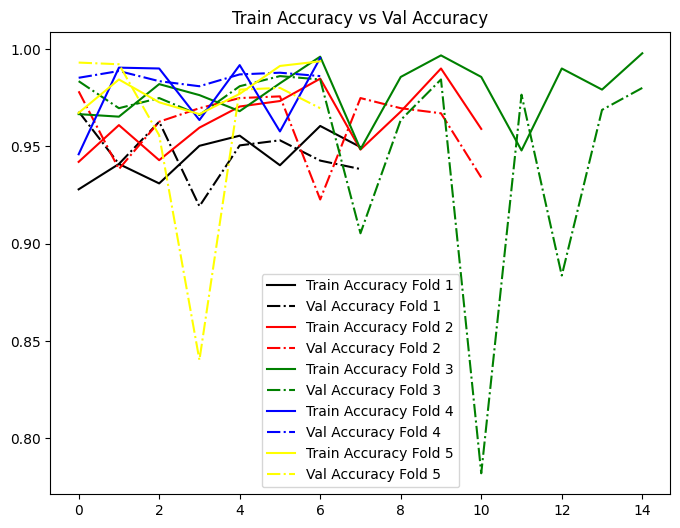

In [31]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='yellow', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='yellow', linestyle = "dashdot")
plt.legend()
plt.show()

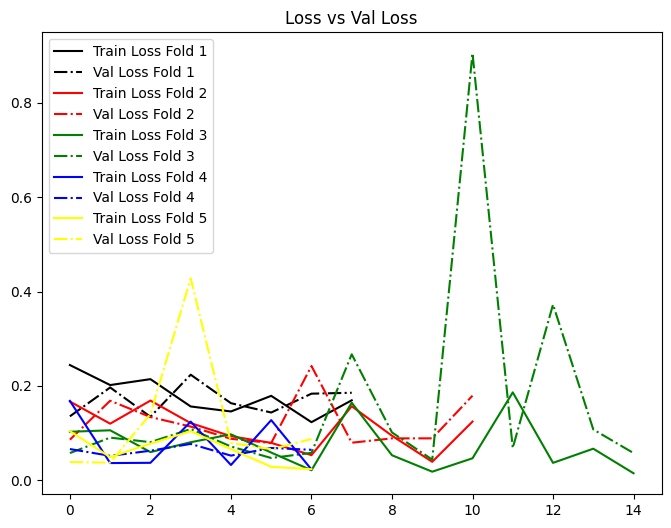

In [32]:
plt.figure(figsize=(8,6))
plt.title('Loss vs Val Loss')
plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='yellow', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='yellow', linestyle = "dashdot")
plt.legend()
plt.show()

In [33]:
y_preds =  model.predict(X_test)
y_preds

45/45 [==============================] - 92s 2s/step


array([[2.1820528e-11, 9.5113755e-05, 9.9974638e-01, 1.5844654e-04],
       [1.0586952e-05, 3.0981946e-06, 2.5955434e-03, 9.9739081e-01],
       [2.2896560e-07, 5.7989670e-13, 9.7304620e-10, 9.9999976e-01],
       ...,
       [9.9085414e-01, 9.1455849e-03, 2.5085821e-11, 2.0118941e-07],
       [9.3762976e-01, 6.2359624e-02, 2.2722295e-09, 1.0594964e-05],
       [2.7189240e-05, 9.9967432e-01, 7.0311318e-05, 2.2817570e-04]],
      dtype=float32)

In [34]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([2, 3, 3, ..., 0, 0, 1], dtype=int64)

In [35]:
asd = np.argmax(Y_test, axis=1)
asd

array([2, 3, 3, ..., 0, 0, 1], dtype=int64)

In [36]:
confusion_matrix(asd,y_preds_arg)

array([[305,  28,   0,   0],
       [  1, 355,   1,   0],
       [  0,   0, 374,   0],
       [  3,   1,  20, 352]], dtype=int64)

In [37]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       333
           1       0.92      0.99      0.96       357
           2       0.95      1.00      0.97       374
           3       1.00      0.94      0.97       376

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



In [38]:
def draw_confusion_matrix(true, preds, class_names):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True, fmt='g', cmap="viridis", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

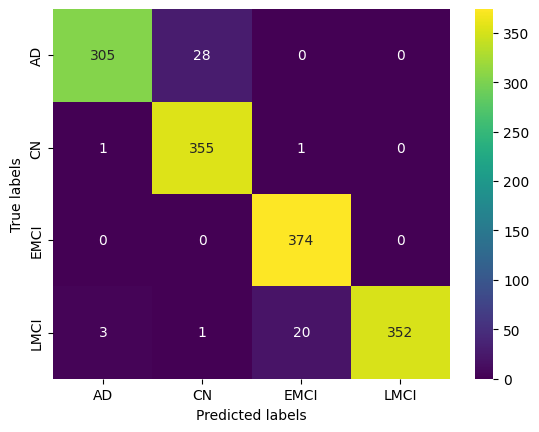

In [39]:
draw_confusion_matrix(asd, y_preds_arg, class_names)

In [40]:
# Ambil nilai val_loss terendah dari setiap fold
val_losses = [min(history.history['val_loss']) for history in model_history]

# Temukan indeks fold terbaik
best_fold_index = val_losses.index(min(val_losses))

# Cetak indeks fold terbaik dan nilai val_loss terendah
print("Best Fold Index:", best_fold_index)
print("Best val_loss:", val_losses[best_fold_index])

Best Fold Index: 4
Best val_loss: 0.037344176322221756


In [41]:
# Pilih history dari fold terbaik
best_history = model_history[best_fold_index]

best_loss = best_history.history['loss'][-1] 
best_accuracy = best_history.history['accuracy'][-1] 
best_specificity = best_history.history['specificity'][-1]  
best_sensitivity = best_history.history['sensitivity'][-1]  

# Cetak nilai-nilai tersebut
print("Best Loss:", best_loss)
print("Best Accuracy:", best_accuracy)
print("Best Specificity:", best_specificity)
print("Best Sensitivity:", best_sensitivity)

Best Loss: 0.02355215884745121
Best Accuracy: 0.9937065839767456
Best Specificity: 0.9980469942092896
Best Sensitivity: 0.9926215410232544
